### 1. Import Packages

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
from pandas_datareader import data
import datetime
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas_datareader.data as pdr

from scipy.optimize import minimize

import sys; sys.path.append('../')
from src.models import *

### 2. Setting Tickers and Functions

In [2]:
# Market Capitalization Top-Ranked Companies in U.S.
tickers = ['AAPL', 'ADBE', 'AMZN', 'BAC', 'CMCSA', 'CSCO', 'CVX', 'DIS',
           'GOOG', 'HD', 'INTC', 'JNJ', 'JPM', 'KO', 'MA', 'MSFT', 'NFLX', 'NKE',
           'NVDA', 'ORCL', 'PFE', 'PG', 'T', 'TM', 'TSLA', 'UNH', 'V', 'VZ', 'WMT',
           'XOM']

# Data loading
start = (2010, 1, 1) 
start_time = datetime.datetime(*start)  
end = (2020, 12, 31) 
end_time = datetime.datetime(*end) 

In [3]:
# Setting Device - If you have gpu, you can change the device 'gpu'
device = torch.device('cpu')

In [4]:
def MAE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred)))

def MSE(y_true, y_pred):
    return np.mean(np.square((y_true - y_pred)))

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred))))

def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MPE(y_true, y_pred): 
    return np.mean((y_true - y_pred) / y_true) * 100

### 3. Setting Hyperparameters and Training Data

In [5]:
num_epochs = 10000
learning_rate = 0.001

# num_epochs = 1000
# learning_rate = 0.01

input_size = 6 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked LSTM layers

num_classes = 1 #number of output classes 

In [6]:
df_results_rnn = pd.DataFrame()
df_metrics_rnn = pd.DataFrame()
df_results_gru = pd.DataFrame()
df_metrics_gru = pd.DataFrame()
df_results_lstm = pd.DataFrame()
df_metrics_lstm = pd.DataFrame()
df_results_lstm_dropout = pd.DataFrame()
df_metrics_lstm_dropout = pd.DataFrame()

results = [df_results_rnn, df_results_gru, df_results_lstm, df_metrics_lstm_dropout]
metrics = [df_metrics_rnn, df_metrics_gru, df_metrics_lstm, df_metrics_lstm_dropout]
experiments = ['RNN', 'GRU', 'LSTM', 'LSTM dropout']
nets = [RNN_model, GRU_model, LSTM_model, LSTM_model]
dropouts = [0, 0, 0, 0.2]
num_layers = [num_layers, num_layers, num_layers, num_layers+1]

In [7]:
for i in range(len(tickers)):
#     df = pd.read_csv('./stock_price_data/' + tickers[i]+'.csv', index_col = 0)
    df = pdr.DataReader(tickers[i], 'yahoo', start_time, end_time)
    X = df # Using high price, low price, Open price, Close price, Volume, and Adjusted Close Price to predict adjusted close price
    y = df.iloc[:, 5:6] #Predicting adjusted close price

    MMS = MinMaxScaler()

    X_data = MMS.fit_transform(X)
    y_data = MMS.fit_transform(y) 

    train_pct = 0.8
    split = int(train_pct * len(X))
    # Input Variables (6 variables)
    X_train, X_test, y_train, y_test = X_data[:split, :], X_data[split+1:-1 :], y_data[1:split+1, :], y_data[split+2:, :] 
    #We trained 2000 - 2018 data including high price, low price, open price, close price, volume, and adj close data

    X_train_tensors = Variable(torch.Tensor(X_train))
    X_test_tensors = Variable(torch.Tensor(X_test))

    y_train_tensors = Variable(torch.Tensor(y_train))
    y_test_tensors = Variable(torch.Tensor(y_test))

    X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
    X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 
    print(20*'-')
    print(tickers[i])
    
    for exp, e in zip(experiments, range(len(experiments))):
        print('Training %s ...' % exp)
        net = nets[e](num_classes, input_size, hidden_size, num_layers[e], X_train_tensors_final.shape[1], dropout=dropouts[e]).to(device)

        loss_function = torch.nn.MSELoss()    # mean-squared error for regression
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  # adam optimizer

        for epoch in range(num_epochs+1):
            outputs = net.forward(X_train_tensors_final.to(device)) #forward pass
            optimizer.zero_grad() #caluclate the gradient, manually setting to 0

            # obtain the loss function
            loss = loss_function(outputs, y_train_tensors.to(device))

            loss.backward() #calculates the loss of the loss function

            optimizer.step() #improve from loss, i.e backprop

            if epoch % 1000 == 0:
                print("Epoch: %d, Loss: %1.4f" % (epoch, loss.item()))

        X_data = MMS.fit_transform(X_test)
        y_data = MMS.fit_transform(y_test) 

        df_X = Variable(torch.Tensor(X_data))
        df_y = Variable(torch.Tensor(y_data))

        df_X = torch.reshape(df_X, (df_X.shape[0], 1, df_X.shape[1]))
        net.eval()
        train_predict = net(df_X.to(device))#forward pass
        y_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
        y_true = df_y.data.numpy()

        y_predict = MMS.inverse_transform(y_predict) #reverse transformation
        y_true = MMS.inverse_transform(y_true)
        metrics_value = pd.DataFrame([MAE(y_true, y_predict), MSE(y_true, y_predict), RMSE(y_true, y_predict), MAPE(y_true, y_predict), MPE(y_true, y_predict)])
        metrics_value.columns = [tickers[i]]
        metrics_value.index = ['MAE', 'MSE', 'RMSE', 'MAPE', 'MPE']
        metrics[e] = pd.concat([metrics[e], metrics_value], axis = 1)
        df_results_temp = pd.DataFrame(y_predict)
        df_results_temp.columns = [tickers[i]]
        results[e] = pd.concat([results[e], df_results_temp], axis=1)

--------------------
AAPL
Training RNN ...
Epoch: 0, Loss: 0.4425
Epoch: 1000, Loss: 0.0068
Epoch: 2000, Loss: 0.0004
Epoch: 3000, Loss: 0.0001
Epoch: 4000, Loss: 0.0001
Epoch: 5000, Loss: 0.0000
Epoch: 6000, Loss: 0.0000
Epoch: 7000, Loss: 0.0000
Epoch: 8000, Loss: 0.0000
Epoch: 9000, Loss: 0.0000
Epoch: 10000, Loss: 0.0000
Training GRU ...
Epoch: 0, Loss: 0.0893
Epoch: 1000, Loss: 0.0002
Epoch: 2000, Loss: 0.0000
Epoch: 3000, Loss: 0.0000
Epoch: 4000, Loss: 0.0000
Epoch: 5000, Loss: 0.0000
Epoch: 6000, Loss: 0.0000
Epoch: 7000, Loss: 0.0000
Epoch: 8000, Loss: 0.0000
Epoch: 9000, Loss: 0.0000
Epoch: 10000, Loss: 0.0000
Training LSTM ...
Epoch: 0, Loss: 0.1066
Epoch: 1000, Loss: 0.0003
Epoch: 2000, Loss: 0.0000
Epoch: 3000, Loss: 0.0000
Epoch: 4000, Loss: 0.0000
Epoch: 5000, Loss: 0.0000
Epoch: 6000, Loss: 0.0000
Epoch: 7000, Loss: 0.0000
Epoch: 8000, Loss: 0.0000
Epoch: 9000, Loss: 0.0000
Epoch: 10000, Loss: 0.0000
Training LSTM dropout ...
Epoch: 0, Loss: 0.0344
Epoch: 1000, Loss: 0.

<ipython-input-4-4c6cb6d4b780>:11: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
<ipython-input-4-4c6cb6d4b780>:14: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean((y_true - y_pred) / y_true) * 100


Epoch: 1000, Loss: 0.0004
Epoch: 2000, Loss: 0.0002
Epoch: 3000, Loss: 0.0002
Epoch: 4000, Loss: 0.0002
Epoch: 5000, Loss: 0.0002
Epoch: 6000, Loss: 0.0002
Epoch: 7000, Loss: 0.0002
Epoch: 8000, Loss: 0.0002
Epoch: 9000, Loss: 0.0002
Epoch: 10000, Loss: 0.0002
Training LSTM ...
Epoch: 0, Loss: 1.4282


<ipython-input-4-4c6cb6d4b780>:11: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
<ipython-input-4-4c6cb6d4b780>:14: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean((y_true - y_pred) / y_true) * 100


Epoch: 1000, Loss: 0.0116
Epoch: 2000, Loss: 0.0042
Epoch: 3000, Loss: 0.0028
Epoch: 4000, Loss: 0.0017
Epoch: 5000, Loss: 0.0005
Epoch: 6000, Loss: 0.0003
Epoch: 7000, Loss: 0.0002
Epoch: 8000, Loss: 0.0002
Epoch: 9000, Loss: 0.0002
Epoch: 10000, Loss: 0.0002
Training LSTM dropout ...
Epoch: 0, Loss: 1.9419


<ipython-input-4-4c6cb6d4b780>:11: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
<ipython-input-4-4c6cb6d4b780>:14: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean((y_true - y_pred) / y_true) * 100


Epoch: 1000, Loss: 0.0426
Epoch: 2000, Loss: 0.0134
Epoch: 3000, Loss: 0.0050
Epoch: 4000, Loss: 0.0043
Epoch: 5000, Loss: 0.0041
Epoch: 6000, Loss: 0.0044
Epoch: 7000, Loss: 0.0039
Epoch: 8000, Loss: 0.0037
Epoch: 9000, Loss: 0.0038
Epoch: 10000, Loss: 0.0038


<ipython-input-4-4c6cb6d4b780>:11: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
<ipython-input-4-4c6cb6d4b780>:14: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean((y_true - y_pred) / y_true) * 100


### 4-1. Saving Metrics

In [8]:
for exp, i in zip(experiments, range(len(experiments))):
    metrics[i].to_csv('results/Results of Error Metrics'+exp+'.csv', encoding = 'utf-8-sig')

### 4-2. Building Datasets

In [9]:
for exp, i in zip(experiments, range(len(experiments))):
    results[i].index = df.iloc[len(df) - len(results[i]):, ].index

In [10]:
df_original = pd.DataFrame()

for i in range(len(tickers)):
#     df = pd.read_csv('./stock_price_data/' + tickers[i]+'.csv', index_col = 0)
    df = pdr.DataReader(tickers[i], 'yahoo', start_time, end_time)
    close = df['Adj Close']
    df_close = pd.DataFrame(close)
    df_close.columns = [tickers[i]]
    df_original = pd.concat([df_original, df_close], axis=1)

ret_daily_original = df_original.iloc[len(df) - len(results[0]) - 251:, ]
ret_daily_original = ret_daily_original.pct_change()
ret_daily_original = ret_daily_original.iloc[1:, ]

n_assets = len(tickers)

ret_daily = []
for exp, i in zip(experiments, range(len(experiments))):
    rd = results[i].pct_change()
    ret_daily.append(rd.iloc[1:, ])

### 5-1. Portfolio Optimization with Stock Price Prediction Results

In [11]:
def obj_sharpe(weights, returns, covmat, rf):
    ret = np.dot(weights, returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(covmat, weights)))
    return 1/((ret-rf)/np.sqrt(vol)) # 1/Sharpe Ratio -> Maximize Sharpe Ratio Using Minimize Function

In [12]:
portfolios = [[]*len(experiments) for _ in range(len(experiments))] # list of lists

for exp, e in zip(experiments, range(len(experiments))):
    for i in range(0, len(ret_daily[e])-1):
        ret_annual = pd.concat([ret_daily_original[i:i+251], ret_daily[e][i:i+1]]).mean() * 252
        cov_annual = pd.concat([ret_daily_original[i:i+251], ret_daily[e][i:i+1]]).cov() * 252
        rf = 0.01
        w0 = np.ones([n_assets])/n_assets
        bnds = tuple((0., 1.) for i in range(n_assets))
        cons = ({'type': 'eq', 'fun': lambda w:  np.sum(w) - 1}) 
        res = minimize(obj_sharpe, w0, (ret_annual, cov_annual, rf), method='SLSQP', bounds=bnds, constraints=cons)
        profit = (ret_daily_original.iloc[i+252] * res.x).sum()
        portfolios[e].append(profit)

In [13]:
portfolios_final = [[]*len(experiments) for _ in range(len(experiments))] # list of lists
std_portfolios = [[]*len(experiments) for _ in range(len(experiments))] # list of lists
Sharpe_ratios = [[]*len(experiments) for _ in range(len(experiments))] # list of lists

for exp, e in zip(experiments, range(len(experiments))):
    portfolios[e] = pd.DataFrame(portfolios[e]) - 0.0003 # Upper bound of security transaction tax
    portfolios[e].index = ret_daily[e].index[1:]
    portfolios[e].columns = ['Portfolio Return']

    data = pd.DataFrame([['2018-10-24',0]], columns=['Date','Portfolio Return'])
    data.index = data['Date']
    data = data.drop(['Date'], axis=1)

    portfolios[e] = pd.concat([data, portfolios[e]])

    c_return = []

    for i in range(0, len(portfolios[e])):
        if i == 0:
            c_return_v_init = 0
            c_return.append(c_return_v_init)
        else:
            c_return_v = (c_return[i-1] + 1) * (portfolios[e]['Portfolio Return'][i] + 1) - 1
            c_return.append(c_return_v)
    c_return = pd.DataFrame(c_return)
    c_return.index = portfolios[e].index

    portfolios_final[e] = pd.concat([portfolios[e], c_return], axis = 1)
    portfolios_final[e].columns = ['Portfolio Return', 'Cumulative Return']

    risk_free_rate = 0.015
    std_portfolios[e] = portfolios[e]['Portfolio Return'][1:].std()
    Sharpe_ratios[e] = (portfolios_final[e]['Portfolio Return'][1:] - risk_free_rate)/std_portfolios[e]
    Sharpe_ratios[e] = Sharpe_ratios[e].mean()
    print('Sharpe ratio (Portfolio with %s Price Prediction Results): %.2f' % (exp, Sharpe_ratios[e]))

Sharpe ratio (Portfolio with RNN Price Prediction Results): -0.33
Sharpe ratio (Portfolio with GRU Price Prediction Results): -0.34
Sharpe ratio (Portfolio with LSTM Price Prediction Results): -0.34
Sharpe ratio (Portfolio with LSTM dropout Price Prediction Results): -0.32


### 5-2. Equally-Weighted Portfolio

In [14]:
portfolio_eqw = []

for i in range(0, len(ret_daily[0])-1):
    weights = np.ones([n_assets])/n_assets
    profit_eqw = (ret_daily_original.iloc[i+252] * weights).sum()
    portfolio_eqw.append(profit_eqw)

portfolio_eqw = pd.DataFrame(portfolio_eqw) 
portfolio_eqw.index = ret_daily[0].index[1:]
portfolio_eqw.columns = ['Portfolio Return']
    
data_eqw = pd.DataFrame([['2018-10-24',0]], columns=['Date','Portfolio Return'])
data_eqw.index = data_eqw['Date']
data_eqw = data_eqw.drop(['Date'], axis=1)

portfolio_eqw = pd.concat([data_eqw, portfolio_eqw])

c_return_eqw = []

for i in range(0, len(portfolio_eqw)):
    if i == 0:
        c_return_eqw_v_init = 0
        c_return_eqw.append(c_return_eqw_v_init)
    else:
        c_return_eqw_v = (c_return_eqw[i-1] + 1) * (portfolio_eqw['Portfolio Return'][i] + 1) - 1
        c_return_eqw.append(c_return_eqw_v)
        
c_return_eqw = pd.DataFrame(c_return_eqw)
c_return_eqw.index = portfolio_eqw.index

portfolio_eqw_final = pd.concat([portfolio_eqw, c_return_eqw], axis = 1)
portfolio_eqw_final.columns = ['Portfolio Return', 'Cumulative Return']

In [15]:
portfolio_eqw

,Portfolio Return
Date,
2018-10-24,0.000000
2018-10-25 00:00:00,0.027426
2018-10-26 00:00:00,-0.016168
2018-10-29 00:00:00,-0.009610
2018-10-30 00:00:00,0.016369
...,...
2020-12-24 00:00:00,0.003451
2020-12-28 00:00:00,0.008781
2020-12-29 00:00:00,0.001416


In [16]:
risk_free_rate = 0.015
std_portfolio_eqw = portfolio_eqw_final['Portfolio Return'][1:].std()
Sharpe_eqw = (portfolio_eqw_final['Portfolio Return'][1:] - risk_free_rate)/std_portfolio_eqw
Sharpe_eqw = Sharpe_eqw.mean()
print('Sharpe ratio (Equally-Weighted Portfolio): %.2f' % Sharpe_eqw)

Sharpe ratio (Equally-Weighted Portfolio): -0.86


In [17]:
portfolio_eqw_final

,Portfolio Return,Cumulative Return
Date,,
2018-10-24,0.000000,0.000000
2018-10-25 00:00:00,0.027426,0.027426
2018-10-26 00:00:00,-0.016168,0.010815
2018-10-29 00:00:00,-0.009610,0.001101
2018-10-30 00:00:00,0.016369,0.017488
...,...,...
2020-12-24 00:00:00,0.003451,0.667724
2020-12-28 00:00:00,0.008781,0.682368
2020-12-29 00:00:00,0.001416,0.684751


### 5-3. Capitalization Weighted Portfolio

In [18]:
from pandas_datareader import data

market_cap_data = data.get_quote_yahoo(tickers)['marketCap']
market_cap = pd.DataFrame(market_cap_data)

In [19]:
market_cap = market_cap / market_cap.sum()

In [20]:
market_cap = np.array(market_cap['marketCap'].tolist())

In [21]:
portfolio_mcw = []

for i in range(0, len(ret_daily[0])-1):
    weights = market_cap
    profit_mcw = (ret_daily_original.iloc[i+252] * weights).sum()
    portfolio_mcw.append(profit_mcw)

portfolio_mcw = pd.DataFrame(portfolio_mcw) 
portfolio_mcw.index = ret_daily[0].index[1:]
portfolio_mcw.columns = ['Portfolio Return']

data_mcw = pd.DataFrame([['2018-10-24',0]], columns=['Date','Portfolio Return'])
data_mcw.index = data_mcw['Date']
data_mcw = data_mcw.drop(['Date'], axis=1)

portfolio_mcw = pd.concat([data_mcw, portfolio_mcw])

c_return_mcw = []

for i in range(0, len(portfolio_mcw)):
    if i == 0:
        c_return_mcw_v_init = 0
        c_return_mcw.append(c_return_mcw_v_init)
    else:
        c_return_mcw_v = (c_return_mcw[i-1] + 1) * (portfolio_mcw['Portfolio Return'][i] + 1) - 1
        c_return_mcw.append(c_return_mcw_v)
        
c_return_mcw = pd.DataFrame(c_return_mcw)
c_return_mcw.index = portfolio_mcw.index

portfolio_mcw_final = pd.concat([portfolio_mcw, c_return_mcw], axis = 1)
portfolio_mcw_final.columns = ['Portfolio Return', 'Cumulative Return']

In [22]:
risk_free_rate = 0.015
std_portfolio_mcw = portfolio_mcw_final['Portfolio Return'][1:].std()
Sharpe_mcw = (portfolio_mcw_final['Portfolio Return'][1:] - risk_free_rate)/std_portfolio_mcw
Sharpe_mcw = Sharpe_mcw.mean()
print('Sharpe ratio (Market Capitalization-Weighted Portfolio): %.2f' % Sharpe_mcw)

Sharpe ratio (Market Capitalization-Weighted Portfolio): -0.78


In [23]:
portfolio_mcw_final.tail()

,Portfolio Return,Cumulative Return
Date,,
2020-12-24 00:00:00,0.004543,0.959102
2020-12-28 00:00:00,0.015843,0.990141
2020-12-29 00:00:00,-0.001051,0.988049
2020-12-30 00:00:00,-0.001693,0.984683
2020-12-31 00:00:00,0.002918,0.990474


### 6. Plotting Cumulative Returns of Portfolios

In [28]:
plt.rcParams["figure.figsize"] = (32,18)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 
plt.rcParams.update({'font.size': 50})
plt.rcParams['lines.linewidth'] = 3

In [25]:
for p in portfolios: p.index = pd.to_datetime(p.index)
portfolio_eqw_final.index = pd.to_datetime(portfolio_eqw_final.index)
portfolio_mcw_final.index = pd.to_datetime(portfolio_mcw_final.index)

In [30]:
# Plot style
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams["figure.dpi"] = 300
plt.rcParams['axes.grid'] = True 
plt.rcParams.update({'font.size': 20})

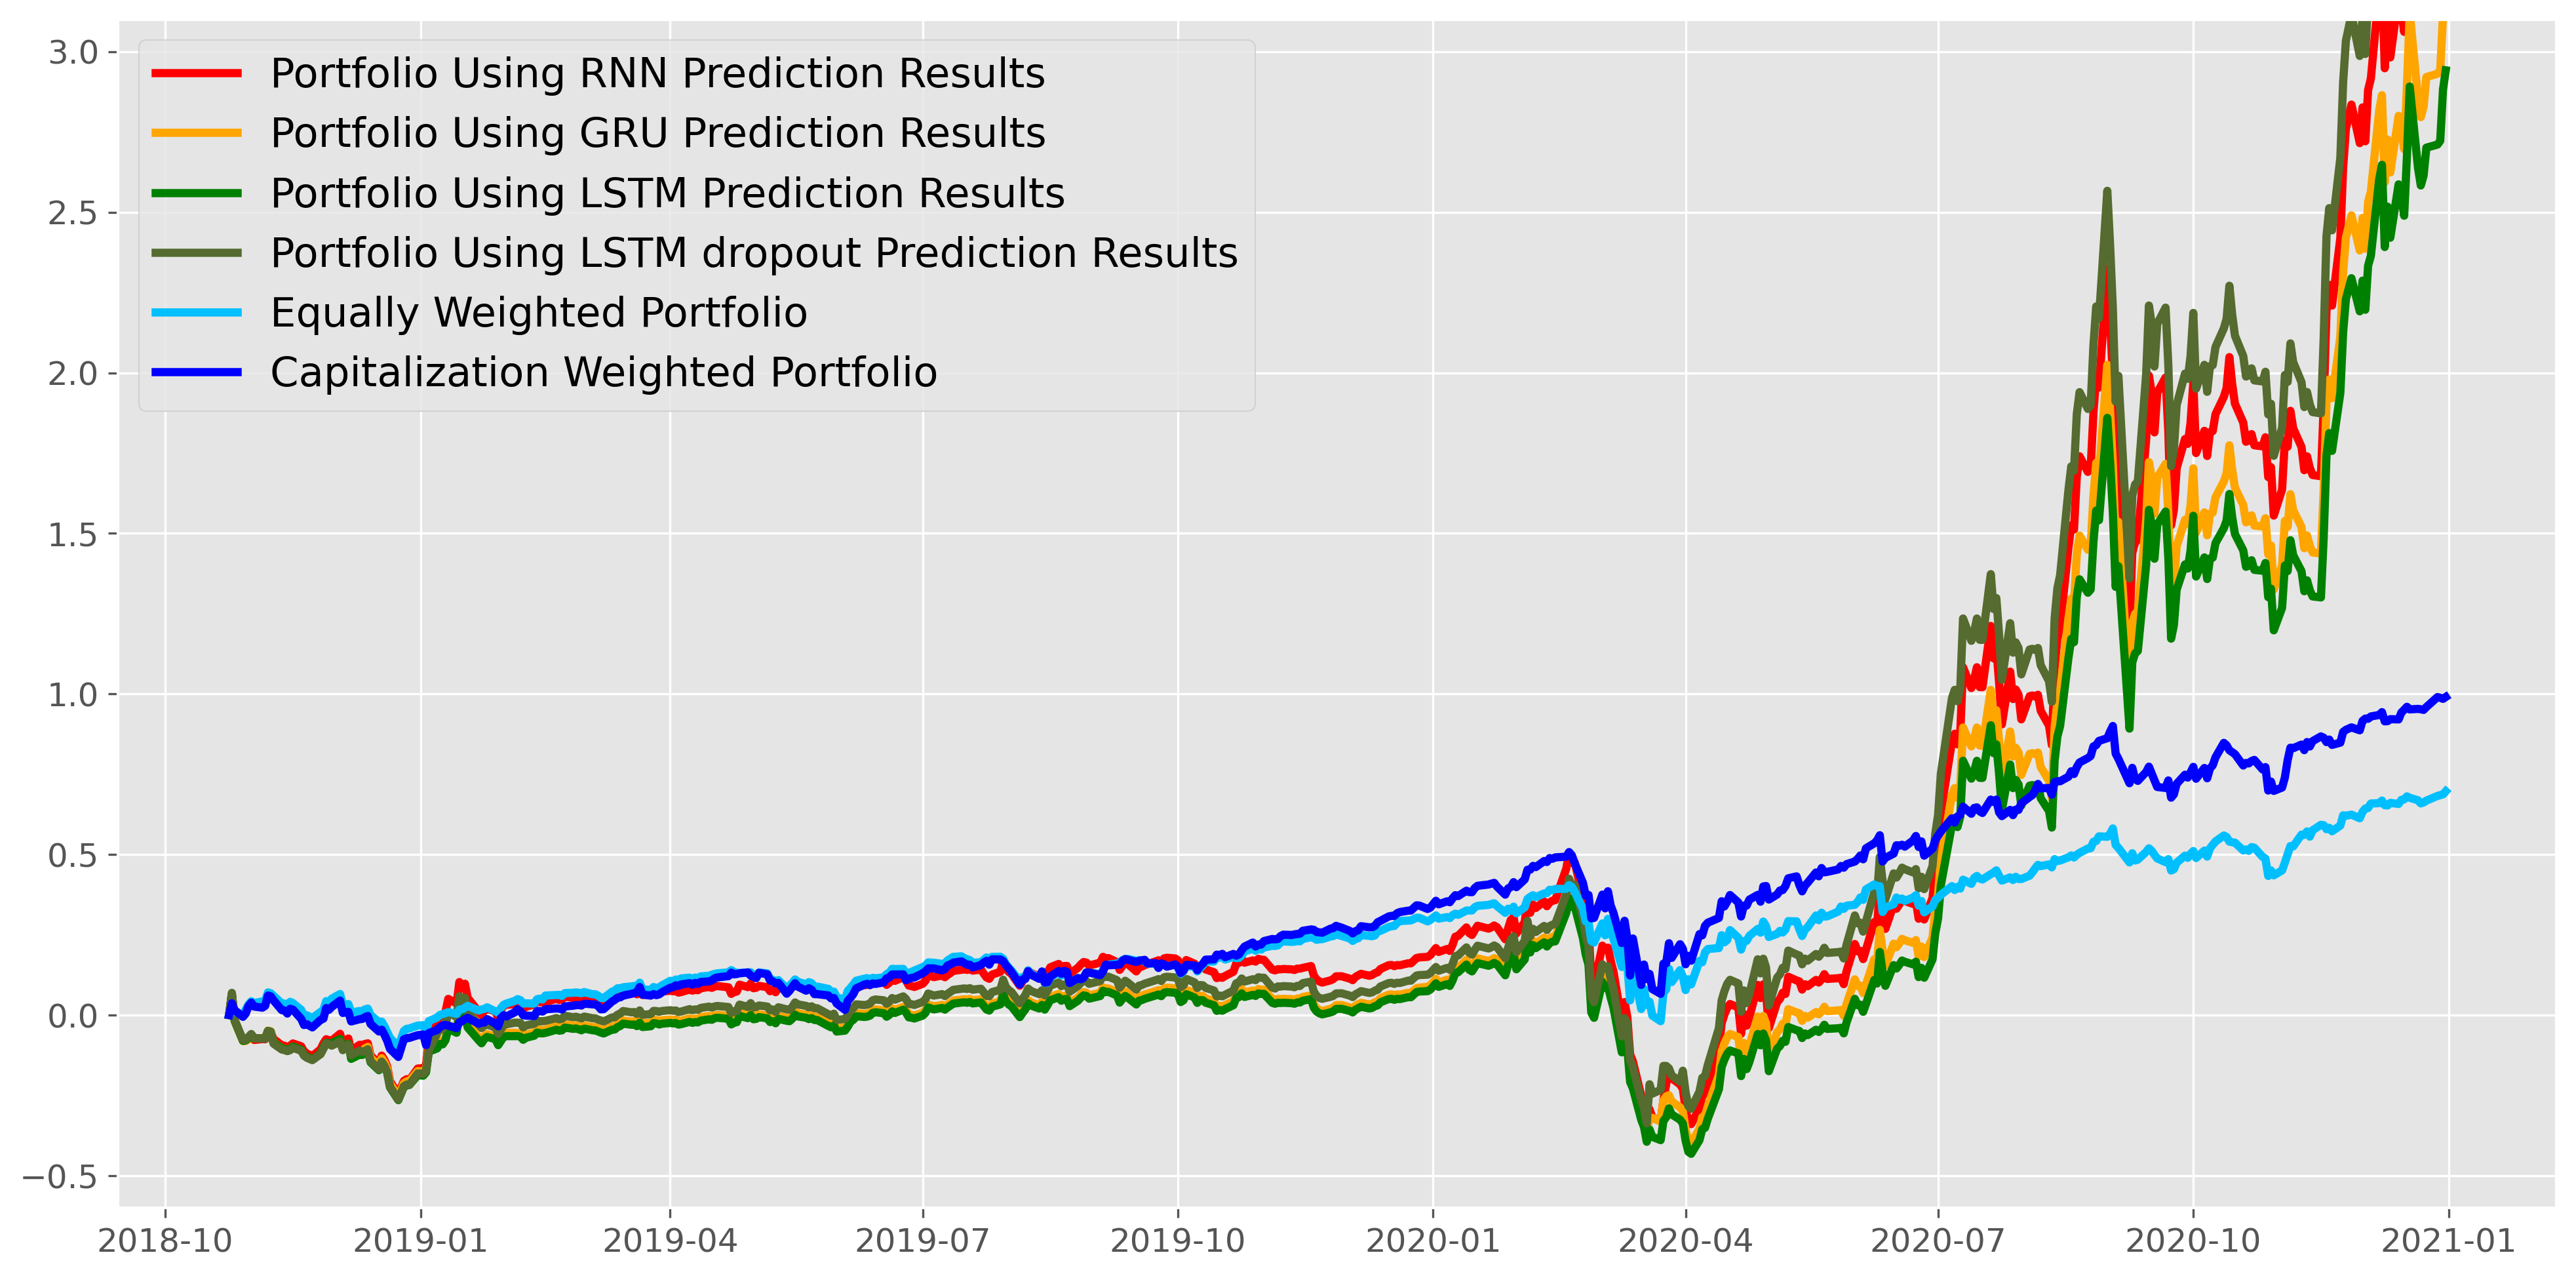

In [31]:
colors = ['red', 'orange', 'green', 'darkolivegreen']
for port, exp, col in zip(portfolios_final, experiments, colors):
    plt.plot(p.index.to_pydatetime(), port['Cumulative Return'], label = 'Portfolio Using ' + exp + ' Prediction Results', color = col)
line2 = plt.plot(portfolio_eqw_final.index.to_pydatetime(), portfolio_eqw_final['Cumulative Return'], label = 'Equally Weighted Portfolio', color = 'deepskyblue')
line3 = plt.plot(portfolio_mcw_final.index.to_pydatetime(), portfolio_mcw_final['Cumulative Return'], label = 'Capitalization Weighted Portfolio', color = 'blue')
plt.xticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim(-0.6, 3.1)
plt.legend(prop={'size':15})
plt.savefig('images/portfolio_multi_same_dset.pdf', bbox_inches='tight')
plt.show()